Histopathologic-Cancer-Detection
==
Identify metastatic tissue in histopathologic scans of lymph node sections  

[Kaggle Playground Prediction Competition](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)


#### Import useful library

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Import trainer and models from fastai and torchvision
from fastai import *
from fastai.vision import *
from torchvision.models import *

data_path = "./training_data/"
image_path = ".training_data/train_data/"

The function below is designed to release unused memory

In [0]:
# Function for memory release
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                  " GPU" if obj.is_cuda else "",
                                                  " pinned" if obj.data.is_pinned else "",
                                                  " grad" if obj.requires_grad else "", 
                                                  " volatile" if obj.volatile else "",
                                                  pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

## Data Analysis

#### Check if positive and negative samples are balanced

In [0]:
data=pd.read_csv(data_path+'train_labels.csv', sep=',')
data['label'].value_counts()

0    101123
1     68902
Name: label, dtype: int64

Negative/Positive ratio is about 10:7  
Samples are not really balanced.

#### Randomly pick some sample from training set

First row are positive samples and seond row are negative samples.  
Positive means that there is tumor tissue in the center region (32 x 32px) of the image

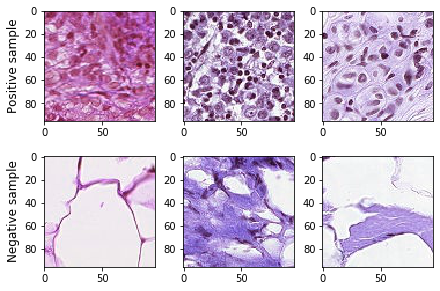

In [0]:
fig, axs = plt.subplots(2, 3, constrained_layout=True)
axs[0,0].set_ylabel('Positive sample', size='large')
axs[1,0].set_ylabel('Negative sample', size='large')

p_sample = data[data['label']==1].sample(n=3)
for index, sample in enumerate(p_sample['id']):
    file = sample+'.tif'
    img = cv2.imread(image_path+file)
    axs[0,index].imshow(img)

n_sample = data[data['label']==0].sample(n=3)
for index, sample in enumerate(n_sample['id']):
    file = sample+'.tif'
    img = cv2.imread(image_path+file)
    axs[1,index].imshow(img)

## Train test split
Split all data into two set -- train and test

In [0]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
print("training size: ",train.shape)
print("testing size: ",test.shape)

training size:  (136020, 2)
testing size:  (34005, 2)


# Why fast.ai?

fast.ai provides a bunch of handy function for building up an image classifier.  
It provides many models based on pytorch and also provides **ImageNet-based pretrained weight**.  
Moreover, we can simply preprocess images with built-in function.

## Image Preprocess and Create data bunch

I use the data augmentation function provided by fastai.vision and create fastai data bunch for training.  
[fastai image augmentation function](https://docs.fast.ai/vision.transform.html)

In [0]:
src = (ImageList.from_df(df=train, path="", folder=image_path, cols="id", suffix='.tif')
       .split_subsets(train_size=0.9, valid_size=0.1)
       .label_from_df(cols="label"))

# Callable variable -> Data augmentation function
tfms = get_transforms(flip_vert=True, max_warp=None)

# Data bunch
data = (src.transform(tfms, size=128)
        .databunch().normalize())

Take a look at the processed data

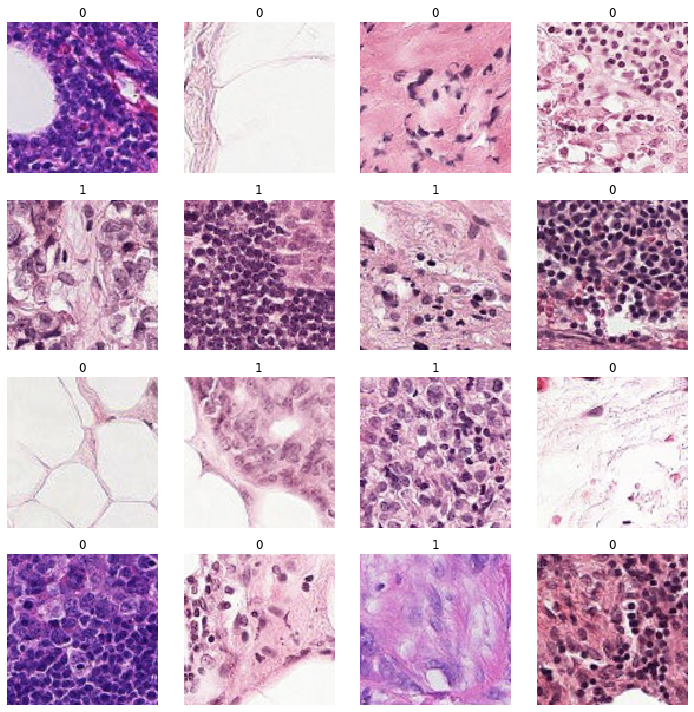

In [0]:
data.show_batch(rows=4, figsize=(10,10))

## Training

As mentioned before, fast.ai provides many model and pretrained weight base on ImageNet. Therefore, I use **transfer learning** strategy here to reduce training time.  

The fastai library includes several pretrained models from torchvision, namely:

    resnet18, resnet34, resnet50, resnet101, resnet152
    squeezenet1_0, squeezenet1_1
    densenet121, densenet169, densenet201, densenet161
    vgg16_bn, vgg19_bn
    alexnet
    
See [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html) and [fastai vision model](https://docs.fast.ai/vision.models.html)    

**Training process:**

    1.  Freeze the weights of pretrained model except output layers.
    2.  Find a best learning rate and use that learning rate to train output layers.
    3.  Unfreeze all weights.
    4.  Find a best learning rate and use that learning rate to fine tune whole model.
    
**One Cycle Policy** is applied for all training process in this program.  
This is proposed by this [paper](https://arxiv.org/abs/1803.09820).  

The proposed strategy suggest to apply low learning rate at first.(Warm up)   
And then gradually increase learning rate to maximum.   
Finally decrease from max to min.

**Parameter:**

    batchsize: default ->64
    epoch: stage1 ->8 
    epoch: stage2 ->12
    learning rate ->depends on 1cycle policy

### Resnet34

I first try resnet34 here. This is just a try, so I don't apply a complete training process

In [0]:
model = resnet34

In [0]:
learn = cnn_learner(data, model, pretrained=True, path='.', metrics=[accuracy, error_rate], ps=0.5, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.312359,0.245905,0.901926,0.098074,09:12
1,0.234433,0.191082,0.925232,0.074768,09:11
2,0.204640,0.176025,0.933980,0.066020,09:10
3,0.198901,0.169764,0.937803,0.062197,09:11


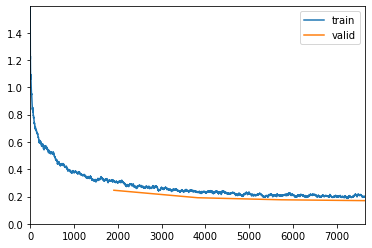

In [0]:
learn.fit_one_cycle(4)

Plot the loss-batch figure.  
From the plot below we can see that the loss is decreasing.

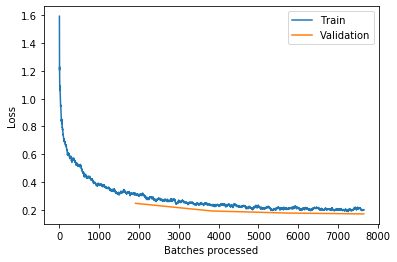

In [0]:
learn.recorder.plot_losses()

The prediction on validation set is shown as below

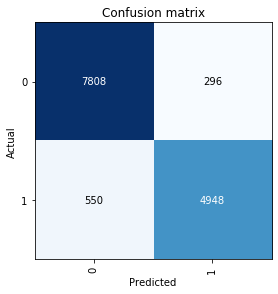

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
learn.save('resnet34-stage1')

In [0]:
learn.export('resnet34.pkl')

In [0]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


### Resnet50

Since resnet34 seems to have good result, I step up to 50 layers and train the model again.  
This time a complete training process is applied.

First, create a new resnet50 network with pretrained weight

In [0]:
model50 = resnet50
learn50 = cnn_learner(data, model50, pretrained=True, path='.', metrics=[accuracy, error_rate], ps=0.5, callback_fns=ShowGraph)

Use learning rate finder to plot the relation between different LR and loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


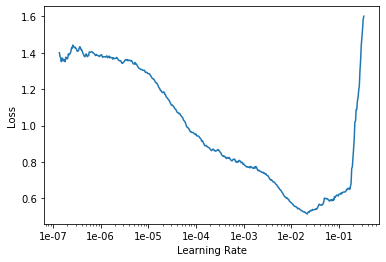

In [0]:
iter_count = 600
learn50.lr_find(num_it=iter_count)
learn50.recorder.plot()

Then use the best learning rate to train output layers.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.289639,0.307769,0.886267,0.113733,18:19
1,0.267702,0.265275,0.898177,0.101823,18:05
2,0.247053,0.246765,0.905970,0.094030,17:53
3,0.236853,0.235551,0.919497,0.080503,17:59
4,0.215698,0.206433,0.925452,0.074548,17:53
5,0.192024,0.180893,0.934054,0.065946,18:00
6,0.165843,0.151722,0.944567,0.055433,17:54
7,0.155199,0.149366,0.946920,0.053080,17:59


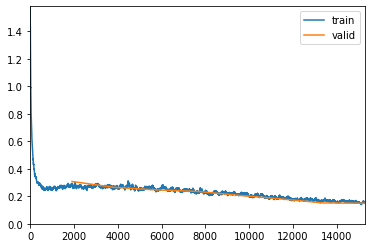

In [0]:
max_lr = 3e-2
# 1cycle policy
learn50.fit_one_cycle(cyc_len=8, max_lr=max_lr)

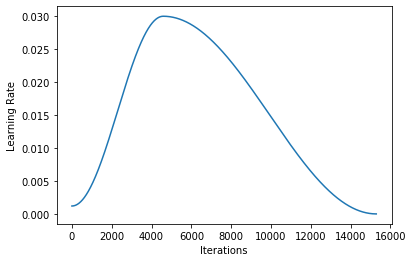

In [0]:
# Plot learning changing curce
learn50.recorder.plot_lr()

In [0]:
learn50.save('resnet50-stage1')

Unfreeze whole network and use LR finder to find best LR as what I did before.  
Also, remember to release unused memory.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


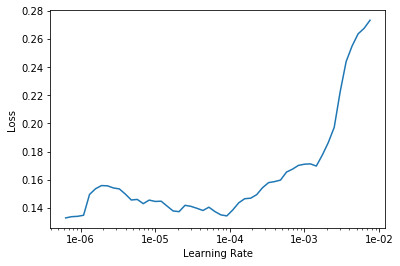

In [0]:
learn50.unfreeze()
learn50.lr_find()
learn50.recorder.plot()

Then use the best learning rate to fine tune whole model.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.167970,0.145534,0.949860,0.050140,25:00
1,0.173421,0.150624,0.947802,0.052198,25:00
2,0.154800,0.151551,0.945743,0.054257,25:01
3,0.150651,0.144881,0.947361,0.052639,25:00
4,0.153267,0.148069,0.946920,0.053080,25:00
5,0.139771,0.126022,0.956330,0.043670,25:00
6,0.131152,0.122133,0.959197,0.040803,25:00
7,0.130736,0.117544,0.959197,0.040803,25:00
8,0.130419,0.115775,0.959712,0.040288,24:59
9,0.132574,0.106784,0.963167,0.036833,25:02


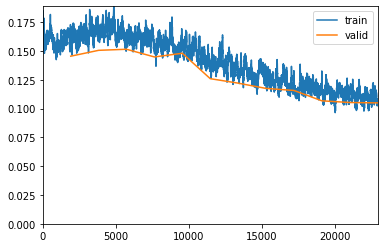

In [0]:
learn50.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,2e-4))

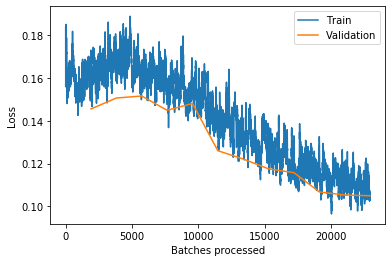

In [0]:
learn50.recorder.plot_losses()

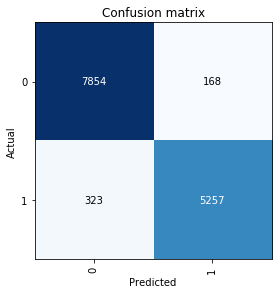

In [0]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_confusion_matrix(title='Confusion matrix')

In [0]:
learn50.save('resnet50-stage2')

In [0]:
learn50.export('resnet50')

In [0]:
learn50.destroy()

this object has been destroyed


# What about deeper network?

Since we have only 4GB GPU memory, we cannot train a deeper resnet on this machine.

## Try other model?

### Resnext 50 with 32x4d template

Here we try an advanced resnet model --Resnext  
I use the same training strategy as mentioned above.  
The model is pretrained with ImageNet dataset.

In [0]:
model = resnext50_32x4d
learn_new = cnn_learner(data, model, pretrained=True, path='.', metrics=[accuracy, error_rate], ps=0.5, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


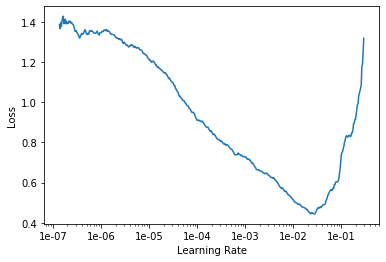

In [0]:
iter_count = 600
learn_new.lr_find(num_it=iter_count)
learn_new.recorder.plot()

I get a better result than normal resnet even if I just retrain the classify layer.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.327516,0.292772,0.880532,0.119468,31:22
1,0.274865,0.720165,0.760991,0.239009,31:09
2,0.254280,0.240483,0.912439,0.087561,31:06
3,0.248745,0.214819,0.919571,0.080429,31:08
4,0.232211,0.206972,0.922291,0.077709,31:06
5,0.200169,0.196499,0.926702,0.073298,31:06
6,0.160076,0.150719,0.945449,0.054551,31:06
7,0.157318,0.140288,0.951404,0.048596,31:08


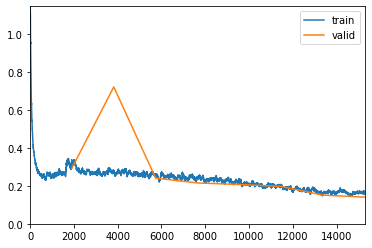

In [0]:
max_lr = 3e-2
# 1cycle policy
learn_new.fit_one_cycle(cyc_len=8, max_lr=max_lr)

In [0]:
learn_new.save('resnext50-stage1')

In [0]:
learn_new.export('resnext50.pkl')

In [0]:
learn_new.load('resnext50-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (122418 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,1,1,0
Path: .;

Valid: LabelList (13602 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,0,0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3),

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


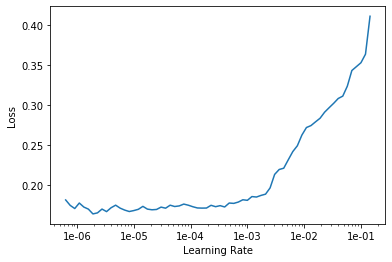

In [0]:
learn_new.unfreeze()
learn_new.lr_find()
learn_new.recorder.plot()

Seems that there is not much I can do with learning rate now.  
I just pick a "not very big" learning rate.  

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.164801,0.141793,0.950595,0.049404,42:54
1,0.146422,0.137765,0.952433,0.047567,42:52
2,0.151997,0.133538,0.952507,0.047493,42:52
3,0.160837,0.135179,0.953316,0.046684,42:58
4,0.146043,0.125452,0.956403,0.043597,42:59
5,0.142387,0.122148,0.957727,0.042273,43:01
6,0.131902,0.119319,0.959050,0.040950,42:59
7,0.127406,0.112434,0.961109,0.038891,43:01
8,0.119675,0.108669,0.963020,0.036980,43:01
9,0.117617,0.107080,0.964343,0.035657,43:05


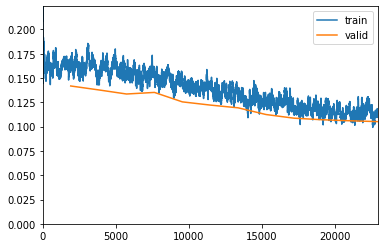

In [0]:
learn_new.fit_one_cycle(cyc_len=12, max_lr=slice(3e-5,3e-4))

In [0]:
learn_new.save('resnext50-stage2')

In [0]:
learn_new.export('resnext50.pkl')

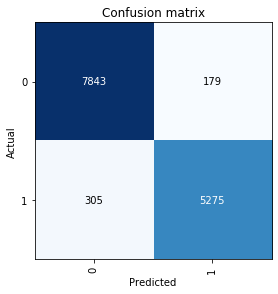

In [0]:
interp = ClassificationInterpretation.from_learner(learn_new)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
dump_tensors(gpu_only=True)

this object has been destroyed
this object has been destroyed
Total size: 0


/home/mladmin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/mladmin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
/home/mladmin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Index.data is deprecated and will be removed in a future version


# Testing

In [0]:
src = (ImageList.from_df(df=test, path="", folder=image_path, cols="id", suffix='.tif'))
model=load_learner(path='./', file='resnext50.pkl', test=src)
preds, *_ = model.get_preds(ds_type=DatasetType.Test)

In [0]:
labels = np.argmax(preds, 1)
np.mean(labels.numpy()==test["label"])

0.9651521835024262

#### Useful link

[introduction to several NN](https://www.ctolib.com/weslynn-AlphaTree-graphic-deep-neural-network.html)  
[fastai CNN learner](https://docs.fast.ai/vision.learner.html#cnn_learner)  
[fastai example](https://www.alexfederation.com/blog/002-oct-cnn/)